In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Subset, DataLoader
import numpy as np
from torch.cuda.amp import autocast, GradScaler

In [ ]:
!gdown 1yWb1OXm7LslxkRx3zHyen-PBZ12-W2sA

Downloading...
From (uriginal): https://drive.google.com/uc?id=1yWb1OXm7LslxkRx3zHyen-PBZ12-W2sA
From (redirected): https://drive.google.com/uc?id=1yWb1OXm7LslxkRx3zHyen-PBZ12-W2sA&confirm=t&uuid=5bffc006-ef82-4ded-9919-d1f42b04392b
To: /media/arh/HDD/HDD_files/UT/ADDNNL/HW1/Q2/efficientnetv2_s_cifar100_finetuned.pth
100%|██████████████████████████████████████| 82.1M/82.1M [00:23<00:00, 3.49MB/s]


In [2]:
# Load EfficientNetV2-S model
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# 100 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 100)
)

# Define a transformation for the CIFAR-100 dataset (make sure it matches the one used during training)
transform = transforms.Compose([
    transforms.Resize(300),  # EfficientNetV2-S expects 300x300 input
    transforms.CenterCrop(260),  # Center crop to 260x260
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Load your pre-trained model weights
model.load_state_dict(torch.load('efficientnetv2_s_cifar100_finetuned.pth'))
model.eval()  # Set the model to evaluation mode
model.cuda()
print("Model Loaded")

Model Loaded


In [3]:
# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Load the CIFAR-100 dataset
cifar100_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)

# Calculate the number of samples you want (20% of the dataset)
# subset_size = int(0.01 * len(cifar100_dataset))

subset_size = int(0.2 * len(cifar100_dataset))



# Create a random subset of 20% of the dataset
subset_indices = torch.randperm(len(cifar100_dataset))[:subset_size]
subset_dataset = Subset(cifar100_dataset, subset_indices)

# Define your DataLoader for the subset
batch_size = 64
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [4]:
features = []
labels = []


with torch.no_grad():
    for inputs, targets  in tqdm(dataloader):
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
        # Forward pass through the model.features
        features_batch = model.features(inputs)
        features_batch = model.avgpool(features_batch)
        features.append(features_batch)
        labels.append(targets)


        # Release GPU memory
        del inputs
        torch.cuda.empty_cache()

100%|█████████████████████████████████████████| 157/157 [00:03<00:00, 41.38it/s]


In [5]:
# Stack and reshape the extracted features
features = torch.cat(features)
features = features.view(features.size(0), -1)
labels = torch.cat(labels)

In [6]:
features.size()

torch.Size([10000, 1280])

In [7]:
labels=labels.unsqueeze(1)  # Make it a 2D tensor

In [8]:
from data_complexity_measures.models.SeprationIndex import Kalhor_SeparationIndex

In [9]:
instance_disturbance = Kalhor_SeparationIndex(features, labels, normalize=True)


data becomes normalized


In [10]:
si_ranked_features, ranked_features = instance_disturbance.forward_feature_ranking_si()

start forward-Selection


100%|█████████████████████████████████████| 1280/1280 [4:15:59<00:00, 12.00s/it]


Ranked features are:  tensor([[ 377., 1273., 1261.,  ..., 1169., 1049.,  855.]])
si for the best chosen Features are:  [[0.0274 0.0449 0.0669 ... 0.6429 0.6425 0.6419]]


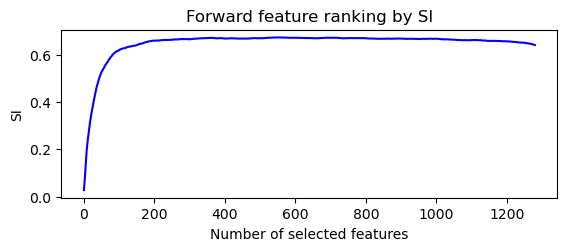

In [11]:
plt.subplot(2, 1, 2)
plt.plot(si_ranked_features.cpu().detach().numpy(), 'b')
plt.xlabel("Number of selected features")
plt.ylabel("SI")
plt.title("Forward feature ranking by SI")
si_ranked_features = torch.transpose(si_ranked_features, 0, 1)
print('Ranked features are: ', ranked_features)
print('si for the best chosen Features are: ', si_ranked_features.detach().cpu().numpy())

In [12]:
ranked_features

tensor([[ 377., 1273., 1261.,  ..., 1169., 1049.,  855.]])

In [13]:
np.max(si_ranked_features.detach().cpu().numpy()[0])

0.6744

In [14]:
si_ranked_features = si_ranked_features.detach().cpu().numpy()[0]
max_index = np.argmax(si_ranked_features)

print("Index of the maximum value:", max_index)


Index of the maximum value: 545


In [15]:
feat = ranked_features[0][:max_index]

In [16]:
feat.size()

torch.Size([545])

In [17]:
len(feat)

545

In [18]:
features_batch.size()

torch.Size([16, 1280, 1, 1])

In [19]:
x = features_batch[:, feat.long(),:,:] 

In [20]:
x.size()

torch.Size([16, 545, 1, 1])

In [21]:
# Train MLP

In [22]:

class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.2):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [23]:
input_size = len(feat)
output_size = 100  
mlp_model = MLPModel(input_size, output_size)

In [24]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
model.to(device)
mlp_model.to(device)

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [25]:
import torchvision

In [26]:
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Training and validation loop
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    mlp_model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for progress bar
    with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as tqdm_loader:
        for inputs, labels in tqdm_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get features using the pretrained model
            features_batch = model.features(inputs)
            features_batch = model.avgpool(features_batch)
            x = features_batch[:, feat.long(), :, :]

            # Forward pass through the MLP model
            outputs = mlp_model(x)

            # Calculate loss and perform backpropagation
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm description with current loss
            tqdm_loader.set_postfix({'Loss': total_loss / total})

    # Calculate training accuracy and loss
    train_accuracy = 100 * correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    mlp_model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_features_batch = model.features(val_inputs)
            val_features_batch = model.avgpool(val_features_batch)
            val_x = val_features_batch[:, feat.long(), :, :]

            val_outputs = mlp_model(val_x)
            val_loss += criterion(val_outputs, val_labels).item()

            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

        # Calculate validation accuracy and loss
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(val_accuracy)

        print(f'Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}%, '
              f'Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}%')

Epoch 1/10: 100%|████████████| 782/782 [00:44<00:00, 17.56batch/s, Loss=0.00648]


Train Loss: 0.41419599418673675, Train Accuracy: 93.272%, Val Loss: 1.5593414264879408, Val Accuracy: 64.17%


Epoch 2/10: 100%|████████████| 782/782 [00:44<00:00, 17.73batch/s, Loss=0.00139]


Train Loss: 0.08903824880985958, Train Accuracy: 98.174%, Val Loss: 1.7491491349639408, Val Accuracy: 64.03%


Epoch 3/10: 100%|███████████| 782/782 [00:44<00:00, 17.73batch/s, Loss=0.000939]


Train Loss: 0.060029274593476595, Train Accuracy: 98.672%, Val Loss: 1.897880528003547, Val Accuracy: 64.05%


Epoch 4/10: 100%|███████████| 782/782 [00:43<00:00, 17.81batch/s, Loss=0.000737]


Train Loss: 0.047141327947268594, Train Accuracy: 98.91%, Val Loss: 2.030767187950717, Val Accuracy: 63.79%


Epoch 5/10: 100%|████████████| 782/782 [00:43<00:00, 17.84batch/s, Loss=0.00062]


Train Loss: 0.03962559335420856, Train Accuracy: 99.054%, Val Loss: 2.153800835275346, Val Accuracy: 64.05%


Epoch 6/10: 100%|███████████| 782/782 [00:43<00:00, 17.83batch/s, Loss=0.000526]


Train Loss: 0.03366048281501426, Train Accuracy: 99.158%, Val Loss: 2.276406872044703, Val Accuracy: 63.87%


Epoch 7/10: 100%|███████████| 782/782 [00:43<00:00, 17.79batch/s, Loss=0.000471]


Train Loss: 0.03010703546508356, Train Accuracy: 99.2%, Val Loss: 2.381517439131524, Val Accuracy: 63.75%


Epoch 8/10: 100%|███████████| 782/782 [00:43<00:00, 17.80batch/s, Loss=0.000429]


Train Loss: 0.027431093888771733, Train Accuracy: 99.274%, Val Loss: 2.488978254567286, Val Accuracy: 63.63%


Epoch 9/10: 100%|███████████| 782/782 [00:44<00:00, 17.65batch/s, Loss=0.000374]


Train Loss: 0.023892969442376642, Train Accuracy: 99.318%, Val Loss: 2.5865020319155065, Val Accuracy: 63.71%


Epoch 10/10: 100%|██████████| 782/782 [00:43<00:00, 17.80batch/s, Loss=0.000361]


Train Loss: 0.0230679059324636, Train Accuracy: 99.354%, Val Loss: 2.664083052592672, Val Accuracy: 63.66%


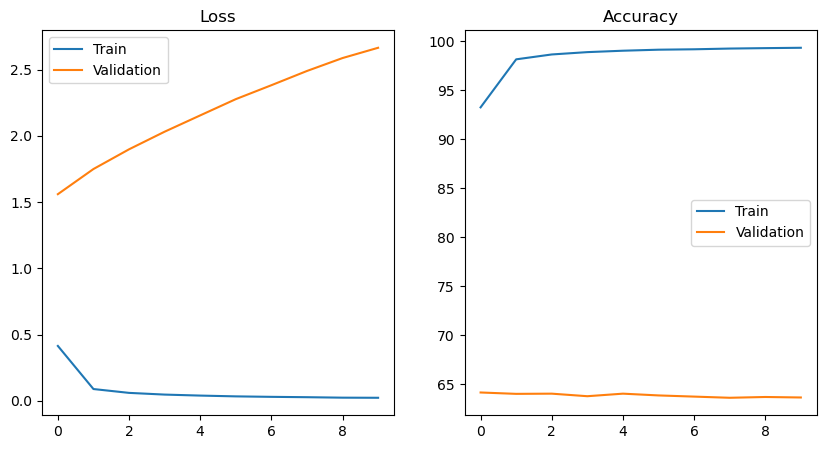

In [28]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Accuracy')
plt.legend()

plt.show()

In [29]:
# Save the trained model
torch.save(mlp_model.state_dict(), 'mlp_model.pth')